# 2D Embeddings using t-SNE, PCA, and MDS

[Kevin McGuinness](http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University

---

Here we're only looking at dimensionality reduction for the purposes of visualization. We will use the MNIST digits dataset (small version included with scikit-learn).

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
np.random.seed(42)

In [ ]:
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

In [ ]:
def plot_mapping(X, y):
    """Aux function that will be used for plotting"""
    figure(figsize=(8,6))
    colors = cm.tab10(np.linspace(0, 1, 9))
    for i in range(9):
        selector = y == i
        Xs = X[selector, :]
        scatter(Xs[:,0], Xs[:,1], label=str(i), 
                c=colors[i], s=60, alpha=0.75, edgecolor='k')
    legend()
    axis('off')

## Load dataset

We're going to use a tiny version of the MNIST dataset. The images are 8x8 pixel images of handwritten digits. This dataset is included in scikit-learn.

In [ ]:
digits = load_digits()
X = digits.data
y = digits.target

There are 1797 examples, each of 64 dimensions (8x8 images)

In [ ]:
print(X.shape)

(1797, 64)


Show the first 200 images on a 10x20 grid:

([], <a list of 0 Text yticklabel objects>)

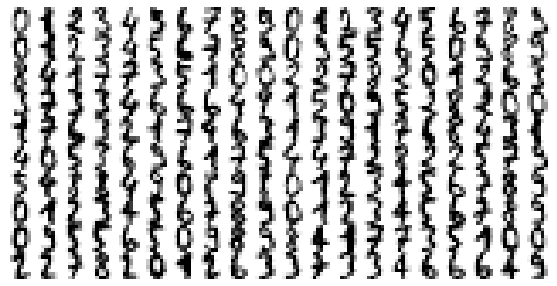

In [ ]:
figure(figsize=(10, 5))
# some reshaping tricks!
imshow(X[:200].reshape(10, 20, 8, 8).transpose(0, 2, 1, 3).reshape(80, 160))
grid(False)
xticks([])
yticks([])

## t-SNE

Use the sklean implementation of t-SNE to map the images to 2-dimensions. This takes a minute or so.

In [ ]:
tsne = TSNE(random_state=101)
X_tsne = tsne.fit_transform(digits.data)

Note that t-SNE gives a different result depending on the initial random starting parameters. In the above line we set the random state to an arbitrary number to ensure the result is always the same.

Try coming back later and changing the random state and re-running the code. You should get a different 2D embedding than the one shown below.

In [ ]:
print(X.shape)
print(X_tsne.shape)

(1797, 64)
(1797, 2)


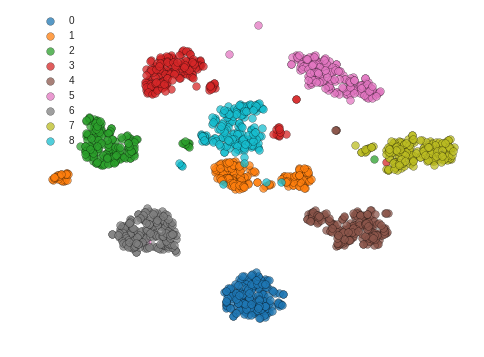

In [ ]:
plot_mapping(X_tsne, digits.target)

The t-SNE embedding nicely separates the different digits into clusters for the most part. This is impressive, since it has never been given access to the target labels.

## Comparison with PCA

Let's compare with the 2D embedding given by PCA

In [ ]:
from sklearn.decomposition import PCA

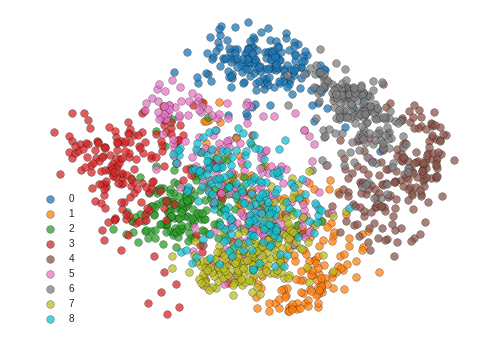

In [ ]:
pca = PCA(2)
X_pca = pca.fit_transform(digits.data)
plot_mapping(X_pca, digits.target)

In this case the separation of the digit classes (0 to 9) is much less clear. 

## Comparison with multi-dimensional scaling

Another method for low-dimensional embedding is multidimensional scaling (MDS). MDS tries to create a distance preserving embedding.

In [ ]:
from sklearn.manifold import MDS

In [ ]:
mds = MDS(2)

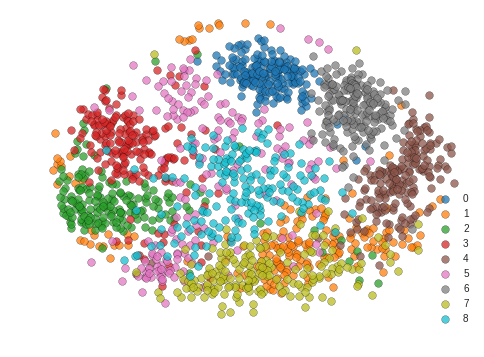

In [ ]:
# takes a while...
X_mds = mds.fit_transform(digits.data)
plot_mapping(X_mds, digits.target)

## Comparison with Isomap

Isomap is a non-linear dimensionality reduction technique. The technique was originally described in 2000 in a paper in Science called ["A Global Geometric Framework for Nonlinear Dimensionality Reduction"](https://web.mit.edu/cocosci/Papers/sci_reprint.pdf), and was considered a big breakthrough at the time. It builds upon MDS, but instead of trying to preserve Eucludean distances, it builds a nearest neighbour graph and tries to preserve Geodesic distances (shortest path distances) on this graph.

In [ ]:
from sklearn.manifold import Isomap

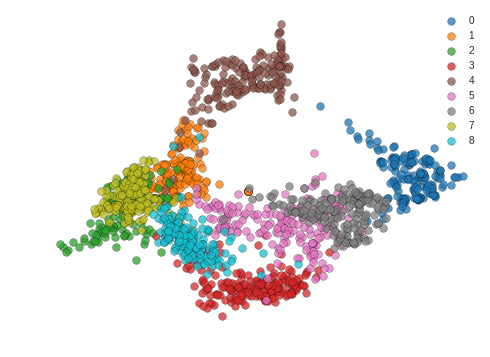

In [ ]:
iso = Isomap()
X_iso = iso.fit_transform(digits.data)
plot_mapping(X_iso, digits.target)

## Using an autoencoder (deep learning)
Non-linear dimensionality reduction using a deep autoencoder! 

You need keras installed to run this bit (https://keras.io/). 

It's also a good idea to turn on hardware acceleration if running in a Colab notebook. (Edit->Notebook Settings)

**Note:** this hasn't been covered in class yet, but is just here for illustration. We'll look at deep learning later.

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers.advanced_activations import ELU

Using TensorFlow backend.


First scale the data to have zero mean and unit variance.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X_scaled = StandardScaler().fit_transform(X) 

Now lets define an autoencoder neural network architecture. We use 3 encoder layers and 3 decoder layers with an embedding dimension of 2.

In [ ]:
encoding_dim = 2  

# Setup out deep neural network
input_img = Input(shape=(X.shape[1],))
encoded = Dense(32, activation='tanh')(input_img)
encoded = Dense(16, activation='tanh')(encoded)
encoded = Dense(8, activation='tanh')(encoded)
encoded = Dense(encoding_dim, activation='tanh')(encoded)
decoded = Dense(8, activation='tanh')(encoded)
decoded = Dense(16, activation='tanh')(decoded)
decoded = Dense(32, activation='tanh')(decoded)
decoded = Dense(X.shape[1], activation='tanh')(decoded)

In [ ]:
encoder = Model(input=input_img, output=encoded)
autoencoder = Model(input=input_img, output=decoded)

In [ ]:
encoder.compile(optimizer='adadelta', loss='mse')
autoencoder.compile(optimizer='adadelta', loss='mse')

Fit the model

In [ ]:
autoencoder.fit(X_scaled, X_scaled,
                nb_epoch=200,
                batch_size=256,
                shuffle=True,
                verbose=2)

Embed the data and plot the results

In [ ]:
X_auto = encoder.predict(X_scaled)

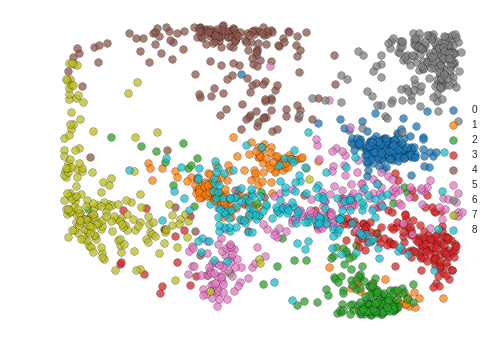

In [ ]:
plot_mapping(X_auto, y)